<a href="https://colab.research.google.com/github/Ramjat19/Handwritten-Digit-Classification-Using-PyTorch-Neural-Network-Approach-/blob/main/B22EE054_pa6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torchvision
import torchvision.datasets as datasets

train_dataset = datasets.MNIST(root='./data', train=True, download=True)
test_data = datasets.MNIST(root='./data', train=False, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 128MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 36.5MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 107MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.62MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
type(train_dataset)

torchvision.datasets.mnist.MNIST

In [5]:
from torchvision import transforms

transform = transforms.Compose([
  transforms.RandomRotation(10),
  transforms.RandomCrop(28, padding=4),
  transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))
])

train_dataset.transform = transform
test_data.transform = transform

In [6]:
train_len = int(0.8*len(train_dataset))
val_len = int(0.2*len(train_dataset))

from torch.utils.data import random_split

train_data, val_data = random_split(train_dataset, [train_len, val_len])


In [7]:
print(train_data)

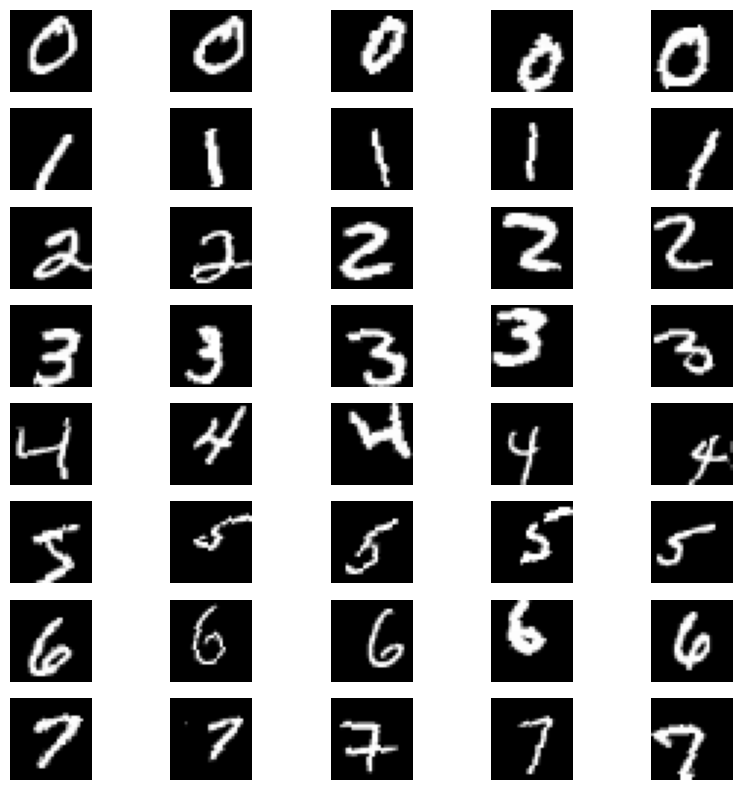

In [8]:
import matplotlib.pyplot as plt

# plotting images for each class from 0 to 9
classes = ['0', '1', '2', '3', '4', '5', '6', '7']
num_samples = 5

fig, axs = plt.subplots(len(classes), num_samples, figsize=(10, 10))

def get_class_indices(dataset, target_class):
  class_indices = []
  for class_idx, class_label in enumerate(dataset.targets):
    if class_label == int(target_class):
      class_indices.append(class_idx)
  return class_indices

def load_image(dataset, index):
  img = dataset[index][0].squeeze()
  return img

def plot_images(axs, dataset, classes, num_samples):
  for i, cls in enumerate(classes):
    cls_indices = get_class_indices(dataset, cls)
    for j in range(num_samples):
      img = load_image(dataset, cls_indices[j])
      axs[i, j].imshow(img, cmap='gray')
      axs[i, j].axis('off')

plot_images(axs, train_dataset, classes, num_samples=5)

#Data loaders

from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [9]:
import torch.nn as nn
import torch.nn.functional as F

def define_MLP():
  class MLP(nn.Module):
    def __init__(self):
      super(MLP, self).__init__()
      self.fc1 = nn.Linear(28 * 28, 128)
      self.fc2 = nn.Linear(128, 64)
      self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
      x = x.view(-1, 28 * 28)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return F.log_softmax(x, dim=1)

  return MLP()

def parameters(model):
  num_trainable_params = 0
  for p in model.parameters():
    if p.requires_grad:
      num_trainable_params += p.numel()
  return num_trainable_params

model = define_MLP()
print(f"Number of trainable parameters: {parameters(model)}")

Number of trainable parameters: 109386


In [10]:
import torch
import torch.optim as optim

# optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

best_val_loss = float('inf')
best_model_path = 'best_model.pth'

# training loop
for epoch in range(1, 6):
  model.train()
  train_loss = 0.0
  correct_train = 0

  for data, target in train_loader:
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    train_loss += loss.item() * data.size(0)
    pred = output.argmax(dim=1, keepdim=True)
    correct_train += pred.eq(target.view_as(pred)).sum().item()

  train_loss /= len(train_loader.dataset)
  train_accuracy = correct_train / len(train_loader.dataset) * 100
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)

  # validation
  model.eval()
  val_loss = 0.0
  correct_val = 0

  with torch.no_grad():
    for data, target in val_loader:
      output = model(data)
      loss = criterion(output, target)
      val_loss += loss.item() * data.size(0)
      pred = output.argmax(dim=1, keepdim=True)
      correct_val += pred.eq(target.view_as(pred)).sum().item()

  val_loss /= len(val_loader.dataset)
  val_accuracy = correct_val / len(val_loader.dataset) * 100
  val_losses.append(val_loss)
  val_accuracies.append(val_accuracy)

  print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

  # best model
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    torch.save(model.state_dict(), best_model_path)

Epoch 1: Train Loss: 1.1419, Val Loss: 0.6798, Val Acc: 78.45%
Epoch 2: Train Loss: 0.5553, Val Loss: 0.4489, Val Acc: 86.04%
Epoch 3: Train Loss: 0.4221, Val Loss: 0.3723, Val Acc: 88.67%
Epoch 4: Train Loss: 0.3621, Val Loss: 0.3500, Val Acc: 89.36%
Epoch 5: Train Loss: 0.3275, Val Loss: 0.3200, Val Acc: 90.02%


<ipython-input-11-30479115a9c5>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Test Loss: 0.3138, Test Acc: 90.24%


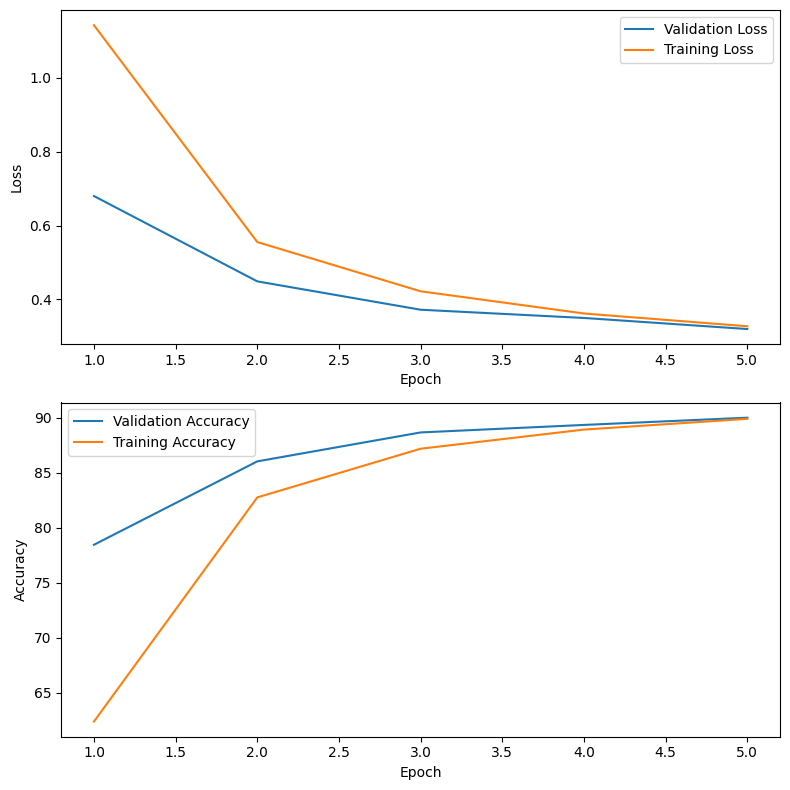

In [11]:
import numpy as np

# best model
model.load_state_dict(torch.load(best_model_path))

# test set evaluation
model.eval()
test_loss = 0.0
correct = 0

predictions = []
true_labels = []

with torch.no_grad():
  for data, target in test_loader:
    output = model(data)
    test_loss += criterion(output, target).item() * data.size(0)
    pred = output.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()

    predictions.extend(pred.cpu().numpy())
    true_labels.extend(target.cpu().numpy())

test_loss /= len(test_loader.dataset)
test_accuracy = correct / len(test_loader.dataset) * 100

print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')

# Visualize correct and incorrect predictions
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

range = np.arange(1, 6)

axs[0].plot(range, val_losses, label='Validation Loss')
axs[0].plot(range, train_losses, label='Training Loss')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend()

axs[1].plot(range, val_accuracies, label='Validation Accuracy')
axs[1].plot(range, train_accuracies, label='Training Accuracy')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend()

plt.tight_layout()
plt.show()